In [1]:
from abc import ABC
import numpy as np
from typing import Tuple, List
from matplotlib import pyplot as plt
from itertools import product
import pandas as pd
from scipy.linalg import inv, norm
from astropy.stats import circmean

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, norm
import sympy as sy
import seaborn as sb
from scipy.stats import vonmises
from astropy.stats import circmean
import filterpy
from filterpy import monte_carlo
from filterpy.monte_carlo import stratified_resample
from filterpy.monte_carlo import systematic_resample
from itertools import product


import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 300

In [2]:
AngleTimeseries = Tuple[np.ndarray, str]

class AngleFilter(ABC):
    def run_filter(self, angles: AngleTimeseries) -> AngleTimeseries:
        """Given angles at each timestep, run a filter on the angles and return filters and errors over time.

        Args:
            angle_timeseries (np.ndarray): The angle data over time.

        Returns:
            np.ndarray: The angles.
        """
        pass
        
    def get_name(self, verbose: bool = False) -> str:
        """Get the name, along with details if applicable.

        Args:
            verbose (bool, defaults to False): whether to add extra detail.


        Returns:
            str: the name of this particle filter.
        """
        pass

In [3]:
def graph_filter(angle_filter: AngleFilter, angles: AngleTimeseries) -> None:
    """Graph an angle timeseries.

    Args:
        angle_filter (AngleFilter): The filter to use.
        angles (AngleTimeseries): The timeseries data.
        graph_title (str): What title to put on the graph.
    """
    
    graph_name = f"{angle_filter.get_name()} on {angles[1]}"

    
    filtered_angles_ts = angle_filter.run_filter(angles)
    filtered_angles, timestamp = filtered_angles_ts
    t = range(len(filtered_angles))
    
    fig, a0, a1 = plt.figure(figsize=(12, 6)), plt.subplot(121), plt.subplot(122, projection="polar")
    a0.plot(t, filtered_angles % (2*np.pi), label="Filtered angle")
    a0.plot(t, angles[0] % (2*np.pi), label="Observed angle")
    a0.legend()

    a1.plot(filtered_angles, np.ones_like(filtered_angles))
    a1.set_yticklabels([])
    fig.suptitle(graph_name)
    fig.show()
    
    fig.savefig(f'actual_paper_graphs/{graph_name.replace(" ", "_")}.pdf')
    

In [4]:
# Define the filters
class LeakyFilter(AngleFilter):
    def __init__(self, N):
        self.N = N
        
    def run_filter(self, angles: AngleTimeseries) -> AngleTimeseries:
        
        filtered_angles = np.zeros_like(angles[0]), "Filtered angles"
        for i in range(len(angles[0])):
            if i < self.N:
                filtered_angles[0][i] = angles[0][i]
            else:
                filtered_angles[0][i] = circmean(np.concatenate([filtered_angles[0][i-self.N+1:i], angles[0][i:i+1]]))
        return filtered_angles
    
    def get_name(self, verbose: bool = False) -> str:
        return f"Leaky Filter (N={self.N})"
    

class KalmanFilter(AngleFilter):
    def __init__(self,F,Q,H,R,u,circular):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matrix for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        # inialize everything
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
        self.circular = circular
        
    def import_csv(self,filename):
        """
        filename: Full filepath of the import csv
        """
        df = pd.read_csv(filename,header=None,index_col=None)
        return df.to_numpy()

    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            The i-th column gives the i-th state.
        obs : ndarray of shape (m,N)
            The i-th column gives the i-th observation.
        """
        
        # set n and m to be useful
        n = len(x0)
        m = len(self.H)

        # initialize and empty state and obs matrices
        states = np.zeros((n, N))
        obs = np.zeros((m,N))

        # do the first pass
        states[:,0] = x0
        obs[:,0] = (self.H @ x0 + np.random.multivariate_normal(mean=np.zeros(m), cov=self.R)) % (2*np.pi)

        for i in range(N-1):
            # iterate 
            states[:,i+1] = (self.F @ states[:,i] + self.u + np.random.multivariate_normal(mean=np.zeros(n), cov=self.Q)) % (2*np.pi)
            obs[:,i] = (self.H @ states[:,i] + np.random.multivariate_normal(mean=np.zeros(m), cov=self.R)) % (2*np.pi)

        # do the last one
        obs[:,-1] = (self.H @ states[:,-1] + np.random.multivariate_normal(mean=np.zeros(m), cov=self.R)) % (2*np.pi)

        # return the states and obs
        return states, obs
    

    def estimate(self,x0,P0,z, return_norms = False):
        """
        Compute the state estimates using the kalman filter.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P0 : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        # get the N, n and initalize an out
        n = len(x0)
        N = z.shape[1]
        out = np.zeros((n, N))

        # set the first value
        out[:,0] = x0

        # iterate 
        for i in range(1,N):
            # we get the temp  by subtracting the observation from the predicted obs
            temp = (z[:,i] - (self.H @ out[:,i-1])) 
            
            # update
            # now yk is either what it is or we shift on the circle no we multiply by the sign to get negatives that are needed
            if self.circular:
                y = []
                for t in temp: # go through all the angles TODO make this nicer
                    if np.abs(t) > np.pi and t < 0: # first we see if the |angle| is bigger than pi and negative then we shift it back 2pi
                        t += 2*np.pi
                    elif np.abs(t) > np.pi and t > 0: # now we see if the angle is positive to shift it forward 2pi
                        t -= 2*np.pi
                    y.append(t)
                # now save it in the array
                yk = np.array(y)
                # yk = np.minimum(np.abs(temp), 2*np.pi - np.abs(temp)) * np.sign(temp)


            else:
                yk = temp
            Sk = self.H @ P0 @ self.H.T + self.R
            Kk = P0 @ self.H.T @ inv(Sk)
            
            
            xk = (out[:,i-1] + Kk @ yk)
            Pk = ((np.eye(n) - Kk @ self.H) @ P0).copy()

            # predict
            out[:,i] = (self.F @ xk + self.u) % (2*np.pi)
            P0 = self.F @ Pk @ self.F.T + self.Q
        
        # return out
        return out
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        # get the n and initialize and out
        n = len(x)
        out =  np.zeros((n,k))

        # set the first value
        out[:,0] = x
        for i in range(1, k):
            # iterate through 
            out[:,i] = self.F @ out[:,i-1] + self.u

        # return out
        return out
             
    def get_name(self, verbose: bool = False) -> str:
        return (
            f"{'Circular' if self.circular else 'noncircular'} KF"
        )
        
    def run_filter(self, angles_ts: AngleTimeseries) -> AngleTimeseries:
        angles, _ = angles_ts
        return self.estimate(np.array([np.pi, np.pi, 0]), np.eye(3)*0.001, np.array([angles]))[0], "Filtered KF angles"

class ParticleFilter(AngleFilter):    
    def __init__(self,F,H,K1,K2,N_particles,n_eff_needed=20):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        K1 : float
            the "circular variance" of the system's noise. Kappa 1.
        H : ndarray of shape (m,n)
            The observation matrix.
        K2 : ndarray of shape (m,m)
            The "circular variance" for observation noise. Kappa 2.
        """
        #Our state vector is:
        #x0=currenet angle, x1 = previous angle, x2 = angular velocity
        
        # inialize everything
        self.K1 = K1
        self.K2 = K2
        self.H = H
        self.F=F
        self.n_eff_needed=n_eff_needed
        #We initialize our particles as 0 angular velocity, uniformly distributed angles on [0,2π]
        self.N_particles = N_particles
        self.particles = np.zeros((N_particles,F.shape[0]))
        self.particles[:,0] = np.random.uniform(0,2*np.pi,N_particles)
        self.particles[:,1] = self.particles[:,0]
        #We initialize the particles weights to all be equal:
        self.weights = 1/N_particles*np.ones(N_particles)
    def creat_uniform_particles(N):
        """
        returns uniformly distributed particles and their weights
        """
        return np.random.uniform(0,2*np.pi,N),1./N * np.ones(N)
    def get_name(self,verbose=False):
        if verbose:
            return f"Particle Filter, K1={self.K1},K2={self.K2},N_particles = {self.N_particles}"
        else:
            return 'Particle Filter'
    def create_von_mises_particles(self,loc,kappa,N):
        """
        returns von mises distributed particles and their weights
        """
        particles = vonmises(loc=loc, kappa=kappa).rvs(N)
        # weights = vonmises(loc=loc, kappa=kappa).pdf(particles)
        return particles#,weights
    def predict_particles(self,particles):
        #predicts the next state of the particles, adding noise into the prediction as well
        #I'm really not sure what kappa variable to use for our noise on both ends
        noise = np.zeros_like(particles)
        noise_new_state = self.create_von_mises_particles(loc=0,kappa=self.K1,N=self.N_particles)
        noise[:,0] = noise_new_state
        #I feel like we don't want noise in our angular velocity estimate or our previous state that we just want to keep track of
        # print(noise_new_state)
        new_particles= particles@(self.F.T) + noise #want to do (F@particles.T).T including noise
        new_particles = new_particles %(2*np.pi)#Make sure it's in the range of 0,2pi
        return new_particles
    
    def update_particles(self,particles,weights,obs):
        """
        obs: (n_obs,) ndarray of observations


        Updates the particle weights using Bayesian Posterior probability.
        P(particle|data) = P(particle)*P(data|particle)
        => new_weight = old_weight * von_mises(data|mean=particle,kappa=K2)
        The "Prior" is just the weight from the previous step.
        The "Likelihood" is just the probability of the data from von mises with mean centered at the particle

        We only calculate the weights based on the current angle estimate, ignoring states 2 and 3

        Returns:
            new_weights: array like weights
        """
        #P(z|particle) = VonMises(loc=particle,Kappa=self.K2).pdf(z)
        # predicted_angles = particles[:,0]

        #Calculate the average likelihood?
        # tot_likelihood = np.zeros_like(weights)
        # for i,ang in enumerate(particles[:,0]):
        #     likelihood = vonmises(loc=ang, kappa=self.K2).pdf(obs)
        #     likelihood = np.mean(likelihood)
        #     tot_likelihood[i] = likelihood
        # tot_likelihood = tot_likelihood#/np.sum(tot_likelihood)  #Make it bigger to avoid tiny floats

        tot_likelihood = np.array([vonmises(loc=mean,kappa=self.K2).pdf(obs) for mean in particles[:,0]]).mean(axis=1)

        #Get the posterior weights
        new_weights = np.copy(weights)
        new_weights = new_weights#/np.sum(weights)
        new_weights = weights*tot_likelihood
        new_weights += 1.e-300 #literally no idea why the original author did this
        #rescale to make them sum to 1 so they're a probability distribution
        new_weights = new_weights/np.sum(new_weights)
        return new_weights

    def state_estimate_from_particles(self,particles,weights):
        #Computes the WEIGHTED circular mean of the particles (just the current angle)
        return circmean(particles[:,0],weights=weights)#%(2*np.pi)

    def resample(self,particles,weights):
        """
        Re-sample from our current particles, using filterpy to do so
        
        Returns:
            particles_chosen
            updated_weights
        """
        particles_chosen = systematic_resample(weights)
        # print(particles_chosen)
        updated_weights = np.ones_like(weights)/self.N_particles
        # updated_weights = weights[particles_chosen]
        # updated_weights = updated_weights/np.sum(updated_weights)

        return particles[particles_chosen,:],updated_weights
    def neff(self,weights):
        #This is the "effective" number of particles. If this falls below a threshold, we need to resample
        return 1. / np.sum(np.square(weights))

    def run_filter_verbose(self,obs):
        """
        Performs the particle filter routine for the entire dataset
        Returns a sequence of state estimates for each time step, as well as particles and effective number of particles
        """
        n_eff_list = np.zeros(obs.shape[1])
        tot_particles = np.zeros((obs.shape[1],self.particles.shape[0],self.particles.shape[1]))
        state_estimates = np.zeros(obs.shape[1])
        for i in range(obs.shape[1]):
            tot_particles[i] = self.particles
            #start by updating the weights of the particles
            current_obs = obs[:,i]
            self.weights = self.update_particles(self.particles,self.weights,current_obs)
            
            #Every so often, we want to resample:
            n_eff_list[i] = self.neff(self.weights)
            if self.neff(self.weights) <= self.n_eff_needed:#.1*self.N_particles:
                # print('resampling successful',self.neff(self.weights))
                self.particles,self.weights = self.resample(self.particles,self.weights)
            #Every so often, we want to resample:
            # if i+1%5==0:#.1*self.N_particles:
            #     # print('resampling successful',self.neff(self.weights))
            #     self.particles,self.weights = self.resample(self.particles,self.weights)
            
            #Compute our state estimate
            state_estimates[i] = self.state_estimate_from_particles(self.particles,self.weights)

            #Predict the next state of the particles
            self.particles = self.predict_particles(self.particles)
        return state_estimates,tot_particles,n_eff_list
    def run_filter(self,angles_ts):
        """
        Performs the particle filter routine for the entire dataset
        Returns a sequence of state estimates for each time step
        For use in the abstract class
        """
        obs, _ =angles_ts
        obs = np.array([obs])
        state_estimates = np.zeros(obs.shape[1])
        for i in range(obs.shape[1]):
            #start by updating the weights of the particles
            current_obs = obs[:,i]
            self.weights = self.update_particles(self.particles,self.weights,current_obs)
            
            #Resample whenever we don't have enough effective particles
            if self.neff(self.weights) <= self.n_eff_needed:
                self.particles,self.weights = self.resample(self.particles,self.weights)
            
            #Compute our state estimate
            state_estimates[i] = self.state_estimate_from_particles(self.particles,self.weights)

            #Predict the next state of the particles
            self.particles = self.predict_particles(self.particles)
        return state_estimates, "Particle filters KF"

/tmp/ipykernel_20423/1213909598.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_20423/1213909598.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_20423/1213909598.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


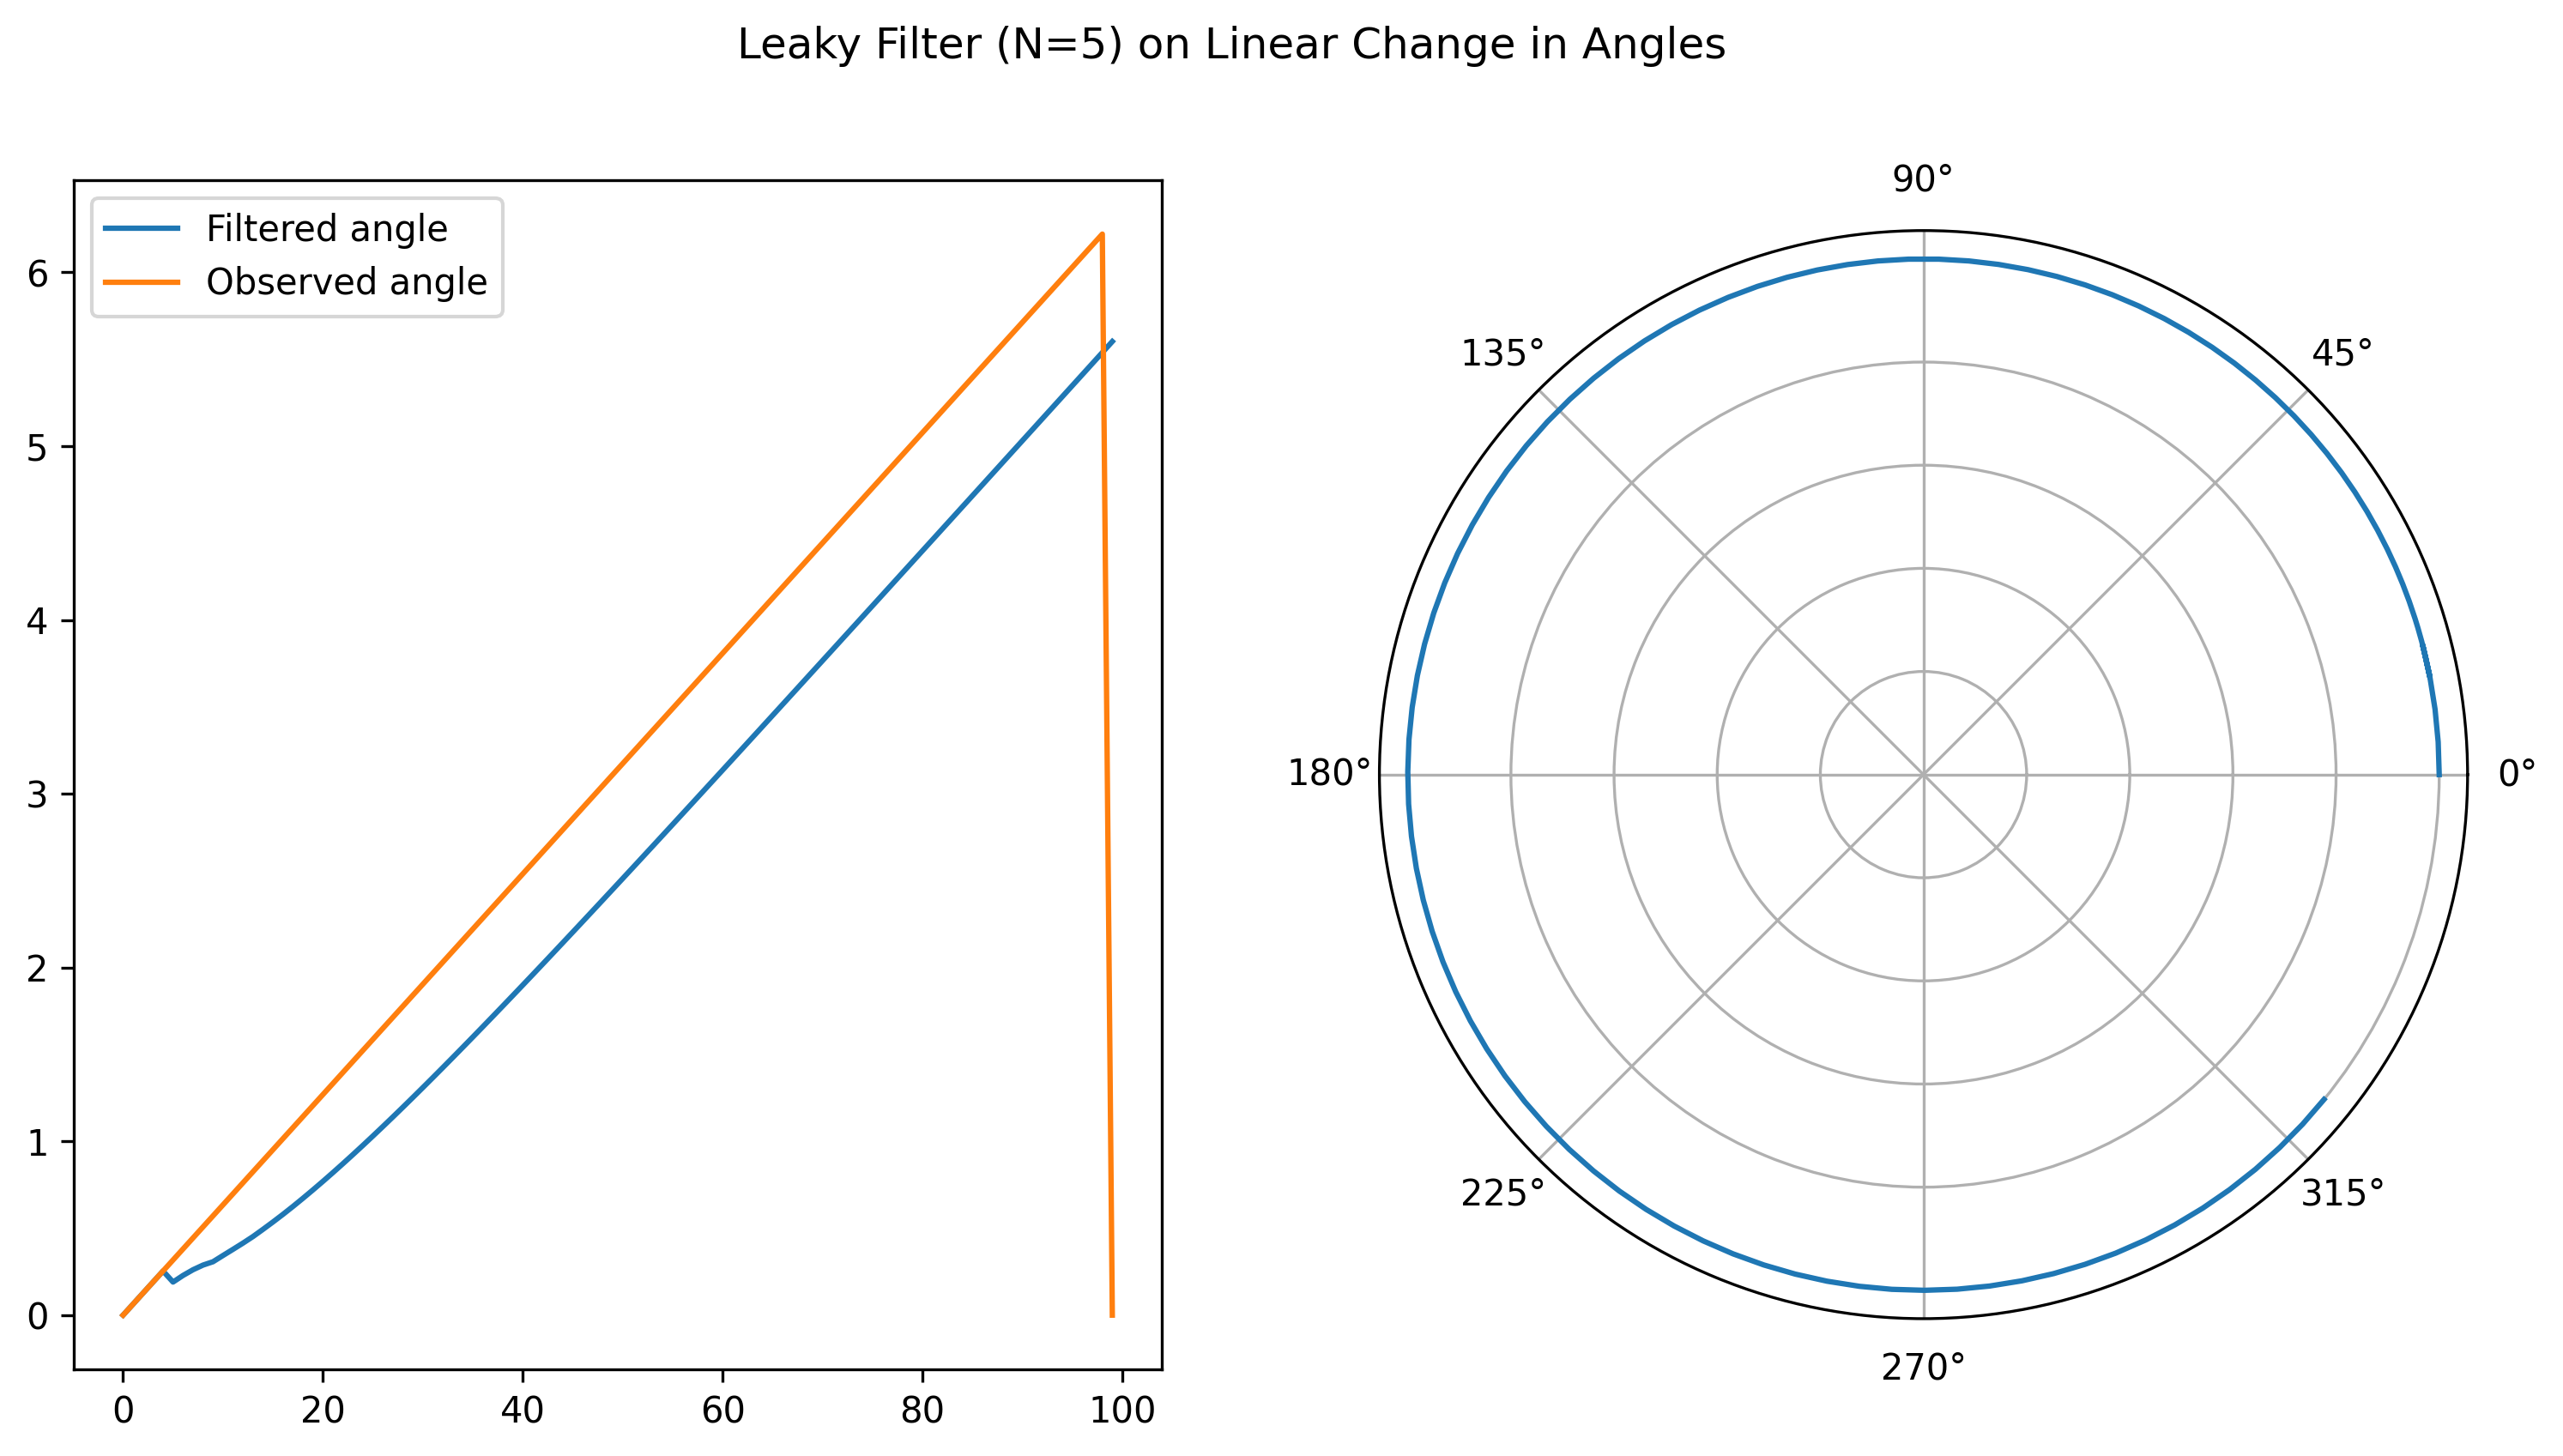

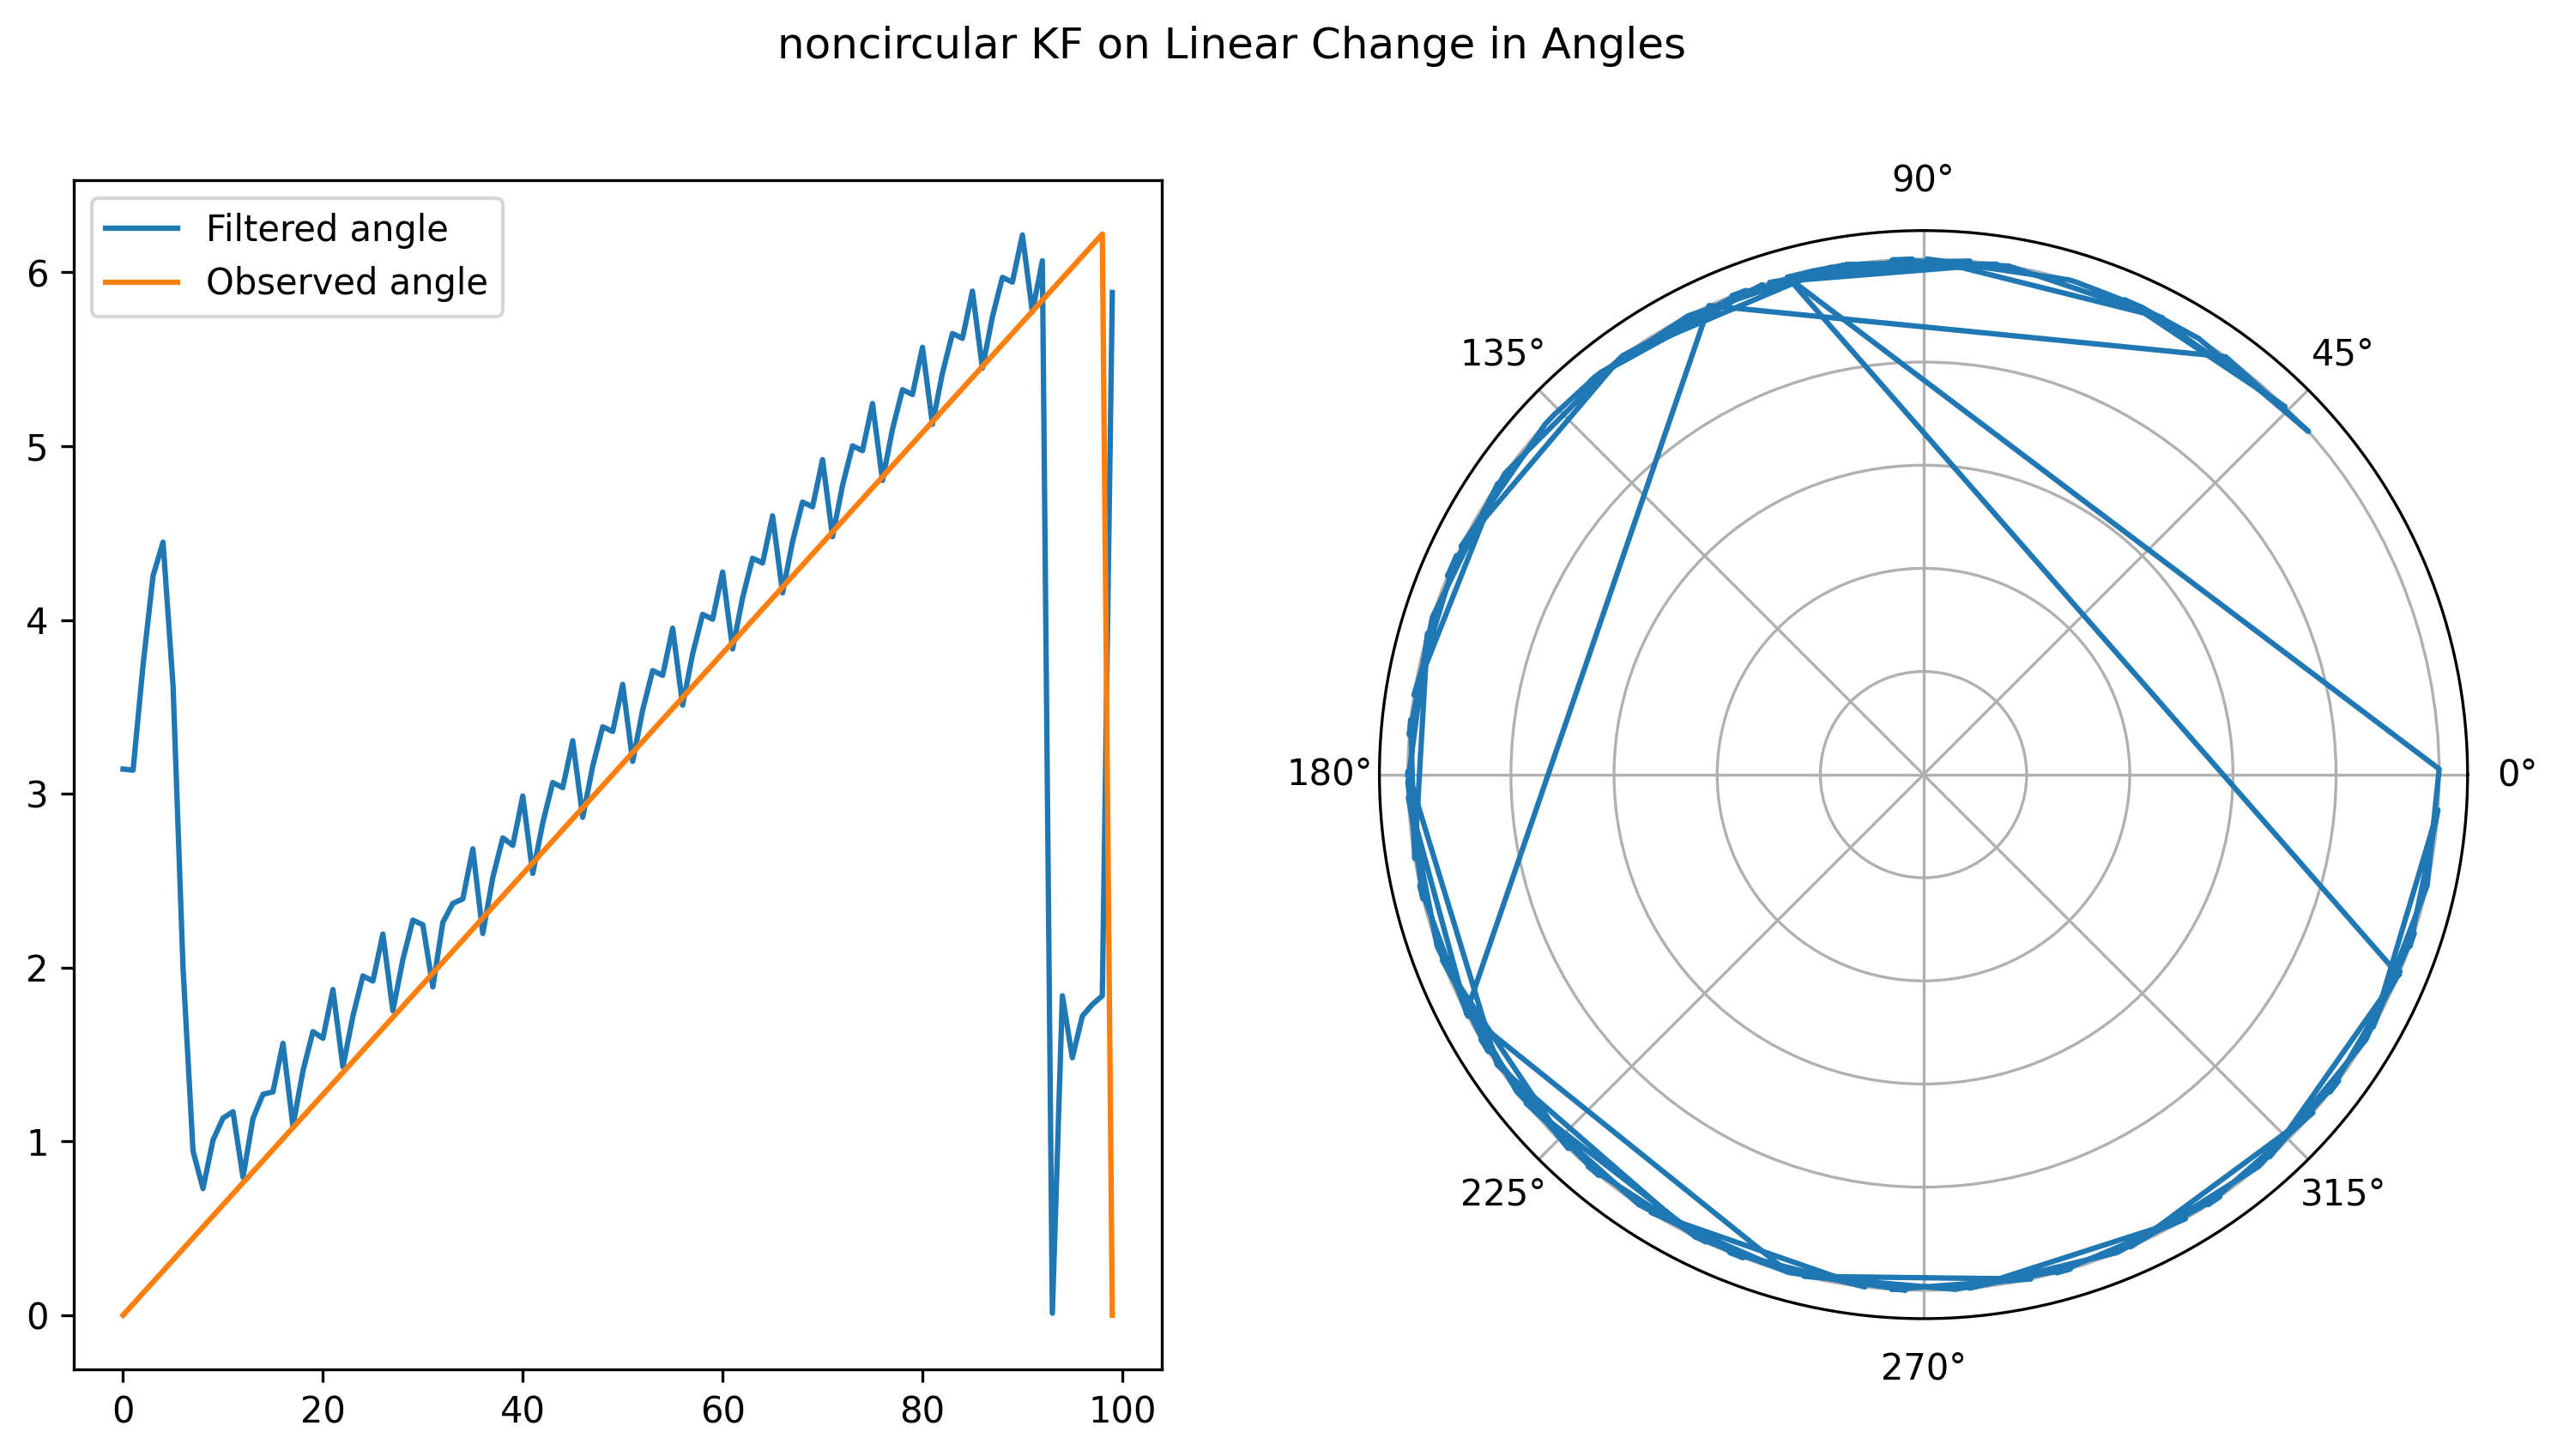

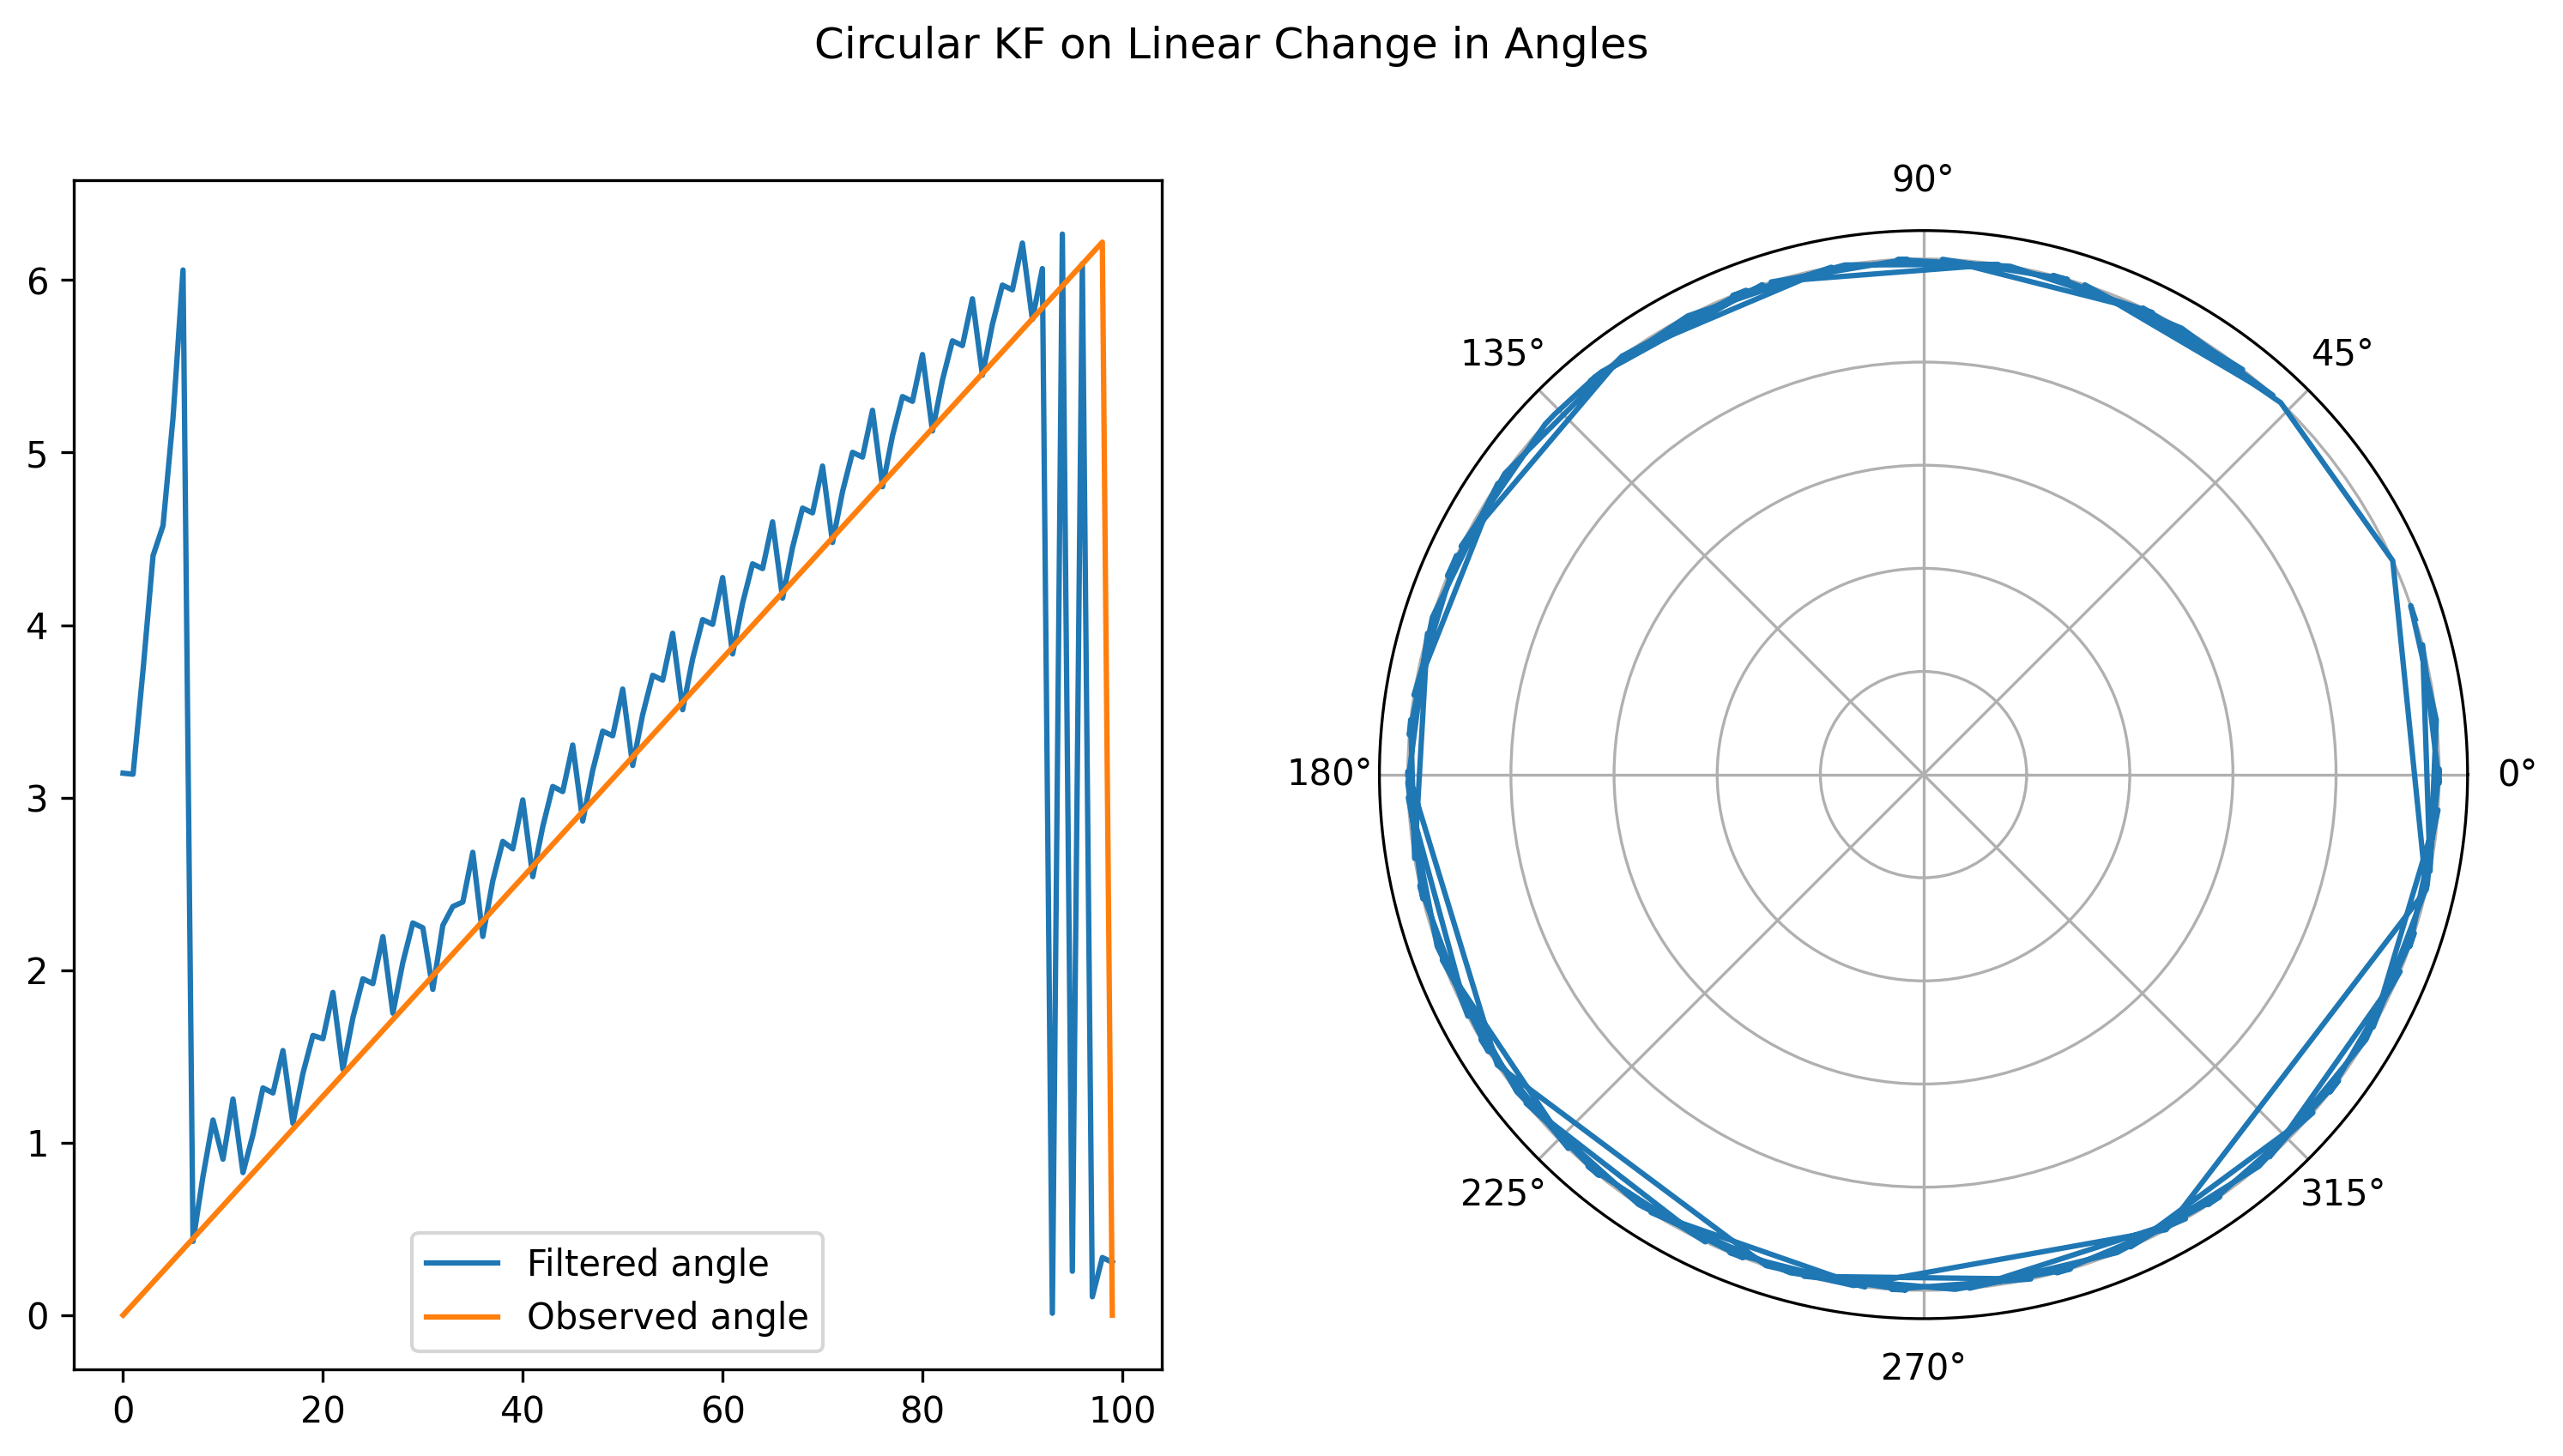

In [5]:
deltat = 0.1
F = np.array([[1,0,deltat],
            [1,0,0],
            [deltat**-1, deltat**-1, 0]])
Q = np.eye(3) * 0.001
theta_dim = 1
H = np.zeros((theta_dim,3))
H[:,0] = np.ones(theta_dim)
R = np.eye(1) * 0.5
u = np.zeros(3)

# Plot various datasets with various tests!
filters = [
    lambda : LeakyFilter(5),
    lambda : KalmanFilter(
        F, Q, H, R, u, False
    ),
    lambda : KalmanFilter(F, Q, H, R, u, True),
    # ParticleFilter(F, H, 1, 1, 500, 25)
]
datasets: List[AngleTimeseries] = [
    (np.linspace(0, 2*np.pi, 100) % (2*np.pi), "Linear Change in Angles"),
    # (np.concatenate([np.pi + np.cos(np.linspace(0, 3*np.pi, 50)), np.pi + np.sin(np.linspace(3*np.pi, 6*np.pi, 50))]) % (2*np.pi), "Discontinuous Angles"),
    # (np.deg2rad(pd.read_csv("Data/test_06_engine_noise_talking_angles.csv",header=None,index_col=None).to_numpy().flatten()), "Real Data")
]

# remove old graphs
import subprocess
subprocess.call(["rm", "-rf", "./actual_paper_graphs/*"])

for dataset, get_angle_filter in product(datasets, filters):
    graph_filter(get_angle_filter(), dataset)